# Vit Transformer

## Модель

In [ ]:
import torch
from torch import nn

In [ ]:
# Смоделируем данные

n_features = 10  # Количество признаков
n_classes = 3  # Количество классов
batch_size = 5 

data = torch.randn((batch_size, n_features))
print(data.shape)
print(data)

torch.Size([5, 10])
tensor([[ 0.5724, -0.6533,  1.1049, -0.4849, -1.7450,  1.1229, -0.9716,  0.7787,
          1.1459, -0.2301],
        [-0.2087, -0.3661, -0.7727,  1.9516,  1.5495,  1.6531, -1.0622,  0.5459,
          0.2340, -1.3714],
        [ 0.1229, -1.1388,  0.8286,  1.2500, -0.6799,  1.2717,  2.5585,  0.5955,
         -0.0385, -0.9558],
        [-0.9188,  1.2414,  0.1035, -0.8419,  1.6002, -0.3624,  0.7136, -0.1262,
         -0.9676, -1.4855],
        [-1.1576,  0.6840, -0.5990, -1.0105,  0.4938, -0.5943,  1.1988, -0.7912,
          1.4762,  0.3026]])


In [ ]:
# Зададим простую модель
model = nn.Linear(n_features, n_classes)

In [ ]:
# Применим модель к вектору
answer = model(data)
print(answer.shape)
print(answer)

torch.Size([5, 3])
tensor([[-0.1430, -0.1978, -0.2459],
        [ 0.0568,  0.2415,  1.2328],
        [ 0.3432,  0.4882, -0.8710],
        [-0.0182,  0.0482,  0.2527],
        [ 0.3254, -0.0420,  0.0331]], grad_fn=<AddmmBackward>)


In [ ]:
# Модель как наследник nn.Module
class SimpleNN(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()

        self.lin = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.lin(x)

In [ ]:
# Попробуем применить модель в виде класса к данным
model = SimpleNN(n_features, n_classes)

answer = model(data)
print(answer.shape)
print(answer)

torch.Size([5, 3])
tensor([[ 0.5724,  0.0264, -0.9001],
        [ 0.3813,  0.7960, -0.4653],
        [ 0.2878, -0.9297, -0.8761],
        [-0.4443, -0.0975, -0.2454],
        [-0.1670, -0.1594,  0.1794]], grad_fn=<AddmmBackward>)


In [ ]:
!pip install torchsummary
from torchsummary import summary

model = SimpleNN(n_features, n_classes).cuda()

# 5, 10
input_size = (batch_size, n_features)
print(summary(model, input_size))

You should consider upgrading via the '/home/yessense/PycharmProjects/scene_vae/venv/bin/python -m pip install --upgrade pip' command.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 5, 3]              33
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
None


In [ ]:
# Модель как sequential
model = nn.Sequential(nn.Linear(n_features, n_classes))

answer = model(data)
print(answer.shape)
print(answer)

In [ ]:
# Модель как nn.ModuleList

model = nn.ModuleList([nn.Linear(n_features, n_classes)])

# answer = model(data)
# print(answer.shape)
# print(answer)

answer = model[0](data)
print(answer.shape)
print(answer)


torch.Size([5, 3])
tensor([[-0.3989, -1.1825,  0.7602],
        [-0.0798,  0.7053, -0.0033],
        [-0.2838, -0.0166, -0.5549],
        [-0.1167,  0.6097, -0.4273],
        [-0.2631,  0.2675, -0.2055]], grad_fn=<AddmmBackward>)


In [ ]:
# Проверим параметры модели
class ParametersCheck(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()

        self.lin = nn.Linear(n_features, n_classes)
        self.seq = nn.Sequential(nn.Linear(n_features, n_classes))
        self.module_list = nn.ModuleList([nn.Linear(n_features, n_classes)])
        self.list_of_layers = [nn.Linear(n_features, n_classes)]


In [ ]:
model = ParametersCheck(n_features, n_classes)

for i, param in enumerate(model.parameters()):
    print(f'Параметр #{i + 1}.')
    print(f'\t{param.shape}')

Параметр #1.
	torch.Size([3, 10])
Параметр #2.
	torch.Size([3])
Параметр #3.
	torch.Size([3, 10])
Параметр #4.
	torch.Size([3])
Параметр #5.
	torch.Size([3, 10])
Параметр #6.
	torch.Size([3])


## ViT

![alt text](https://drive.google.com/uc?export=view&id=1J5TvycDPs8pzfvlXvtO5MCFBy64yp9Fa)

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

![](https://amaarora.github.io/images/vit-01.png)

## Часть 1. Patch Embedding, CLS Token, Position Encoding

![](https://amaarora.github.io/images/vit-02.png)

In [3]:
# input image `B, C, H, W`
x = torch.randn(1, 3, 224, 224)
# 2D conv
conv = nn.Conv2d(3, 768, 16, 16)
conv(x).reshape(-1, 196).transpose(0,1).shape

torch.Size([196, 768])

In [113]:
class PatchEmbedding(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = (img_size, img_size)
        self.patch_size = (patch_size, patch_size)
        self.num_patches = (self.img_size[1] // self.patch_size[1]) * (self.img_size[0] // self.patch_size[0])
        self.patch_embeddings = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, image):
        # B, C, H, W = image.shape # assert
        patches = self.patch_embeddings(image).flatten(2).transpose(1, 2)
        #patches = patches.reshape(-1, 196).transpose(0,1)
        return patches

In [114]:
patch_embed = PatchEmbedding()
x = torch.randn(1, 3, 224, 224)
patch_embed(x).shape 

torch.Size([1, 196, 768])

![](https://amaarora.github.io/images/vit-03.png)

## Часть 2. Transformer Encoder

![](https://amaarora.github.io/images/ViT.png)

![](https://amaarora.github.io/images/vit-07.png)

In [284]:
class MLP(nn.Module):
    def __init__(self, in_features, mlp_ratio, out_features=None, drop=0.):
        super().__init__()
        hidden_features = int(in_features * mlp_ratio)
        out_features = int(in_features if not out_features else out_features)
        
        # Linear Layers
        self.l1 = nn.Linear(in_features, hidden_features)
        self.l2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.l1(x)
        x = F.gelu(x)
        x = self.drop(x)
        x = self.l2(x)
        x = self.drop(x)
        return x

In [147]:
x = torch.randn(1, 197,768)
mlp = MLP(768, 4)
out = mlp(x)
out.shape

torch.Size([1, 197, 768])

In [159]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., out_drop=0.):
        # dim = 768
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.out = nn.Linear(dim, dim)
        self.out_drop = nn.Dropout(out_drop)

    def forward(self, x):
        # линейный слой
        # 1, 197, 768 -> 1, 197, 2304
        qkv = self.qkv(x)
        
        # делим на три равные части
        # 1, 197, 2304 -> 3, 1, 197, 768 
        qkv = qkv.chunk(3, dim=-1)
        
        # destack
        # b - размер батча
        # n - num_heads
        # h - количество патчей + токен (196 + 1)
        # d - dim // num_heads
        # 1, 8, 197, 96
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.num_heads), qkv)

        # q @ k(t)
        # 1, 8, 197, 96 @ 1, 8, 96, 197 ->  1, 8, 197, 197
        attn = q @ k.transpose(-1, -2) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        # attn @ v
        # 1, 8, 197, 197 @ 1, 8, 197, 96 -> 1, 8, 197, 96 
        out = attn @ v
        # 1, 8, 197, 96 -> 1, 197, 768
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.out(out)
        return self.out_drop(out)



![](https://amaarora.github.io/images/vit-08.png)

In [160]:
# attn = (q @ k.transpose(-2, -1)) * self.scale
# attn = attn.softmax(dim=-1)

In [161]:
x = torch.randn(1, 197, 768)
attention = Attention(768, 8)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

In [162]:
class Block(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()

        # Normalization
        self.norm1 = nn.LayerNorm(dim)

        # Attention
        self.attn = Attention(dim, num_heads)

        # Dropout
        self.drop = nn.Dropout(drop_rate)

        # Normalization
        self.norm2 = nn.LayerNorm(dim)

        # MLP
        self.mlp = MLP(dim, mlp_ratio, dim)

    def forward(self, x):
        # Attetnion
        attn = self.norm1(x)
        attn = self.attn(attn)
        x = attn + x

        # MLP
        mlp = self.norm2(x)
        mlp = self.mlp(mlp)
        x = mlp + x
        return x

In [163]:
x = torch.randn(1, 197, 768)
block = Block(768, 8)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

В оригинальной реализации теперь используется [DropPath](https://github.com/rwightman/pytorch-image-models/blob/e98c93264cde1657b188f974dc928b9d73303b18/timm/layers/drop.py)

In [164]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [165]:
x = torch.randn(1, 197, 768)
block = Transformer(12, 768)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

![](https://amaarora.github.io/images/vit-06.png)

In [289]:
from torch.nn.modules.normalization import LayerNorm

class ViT(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=3, 
                 qkv_bias=False, drop_rate=0.,):
        super().__init__()

        # Path Embeddings, CLS Token, Position Encoding
        self.patch_embed = PatchEmbedding(img_size=img_size,
                                          patch_size=patch_size,
                                          in_chans=in_chans,
                                          embed_dim=embed_dim)
        
        # Присвоение переменных
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # Transformer Encoder
        self.transformer = Transformer(depth, 
                                       embed_dim, 
                                       mlp_ratio=mlp_ratio, 
                                       num_heads=num_heads, 
                                       drop_rate=drop_rate)
        
        
        # Classifier
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes))
     

    def forward(self, x):
        B = x.shape[0]
      
        # Path Embeddings, CLS Token, Position Encoding
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        # Transformer Encoder
        x = self.transformer(x)

        # Classifier
        x = x.mean(dim=1)
        x = self.mlp_head(x)
        return x

In [290]:
x = torch.randn(1, 3, 224, 224)
vit = ViT()
out = vit(x)
out.shape

torch.Size([1, 1000])

# Домашнее задание


1. Выбрать датасет для классификации изображений с размерностью 64x64+ 
2. Обучить ViT на таком датасете.
3. Попробовать поменять размерности и посмотреть, что поменяется при обучении.


Примечание:
- Датасеты можно взять [тут](https://pytorch.org/vision/stable/datasets.html#built-in-datasets) или найти в другом месте.
- Из за того, что ViT учится медленно, количество примеров в датасете можно ограничить до 1к-5к.

In [245]:
import torchvision
from torchvision import transforms as tvt
from torchvision.utils import make_grid
from matplotlib import pyplot as plt 

trans = tvt.Compose([
    tvt.ToTensor(),
    tvt.Resize(64)
])

# STL10 - датасет из картинок 10 классов: 
# airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

# тренировочные картинки, 5к
stl10_train = torchvision.datasets.STL10('./',
                                         split = 'train',
                                         transform=trans,
                                         download=True)
# валидационные картинки, 800
stl10_val = torchvision.datasets.STL10('./',
                                       split = 'test',
                                       transform=trans, 
                                       download=True

Files already downloaded and verified
Files already downloaded and verified


In [312]:
data_loader_train = torch.utils.data.DataLoader(stl10_train,
                                                batch_size=4,
                                                shuffle=True)

data_loader_val = torch.utils.data.DataLoader(stl10_val,
                                              batch_size=4,
                                              shuffle=True)

1


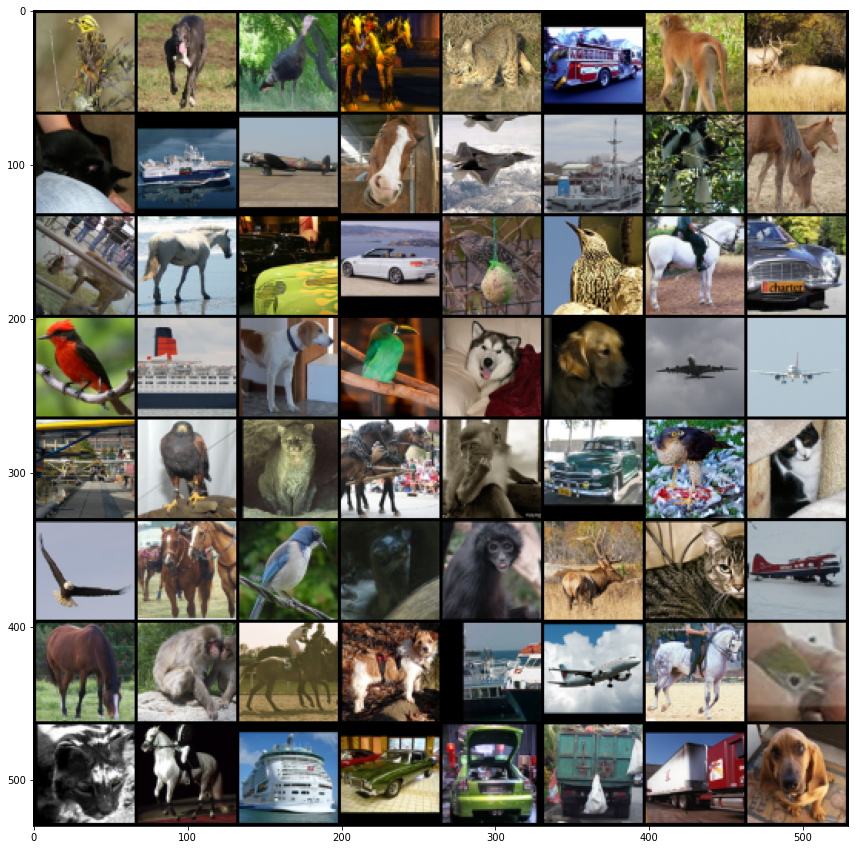

In [241]:
a = stl10_train[0][1]
print(a)
plt.figure(figsize=(15, 15))
l = [i[0] for i in stl10_train][:64]
plt.imshow(make_grid(l).permute(1, 2, 0))

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss
from tqdm import tqdm_notebook

model = ViT(img_size=64, num_classes=10).to(device)
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss().to(device)

epochs = 50
loss_train = []
loss_val = []

acc_train = []
acc_val = []

for epoch in tqdm_notebook(range(epochs)):
    cur_loss = 0
    cur_acc = 0
    batches = 0

    # train
    model.train()
    for X, Y in data_loader_train:
        batches += 1
        Y_one_hot = F.one_hot(Y, 10).to(device).float()
        X = X.to(device)
        optim.zero_grad()
        out = model(X)
        out = out.softmax(dim=1)
        loss = loss_fn(out, Y_one_hot)
        cur_acc += (Y == out.cpu().argmax(1)).float().mean()
        cur_loss += loss.item() / X.shape[0]
        loss.backward()
        optim.step()
    loss_train.append(cur_loss / batches)
    acc_train.append(cur_acc / batches)

    # val
    cur_loss = 0
    cur_acc = 0
    batches = 0
    model.eval()
    for X, Y in data_loader_val:
        batches += 1
        X = X.to(device)
        Y_one_hot = F.one_hot(Y, 10).to(device).float()
        with torch.no_grad():
            out = model(X)
            out.softmax(dim=1)
            loss = loss_fn(out, Y_one_hot)
            cur_loss += loss.item() / X.shape[0]
            cur_acc  += (Y == out.cpu().argmax(1)).float().mean()
    loss_val.append(cur_loss / batches)
    acc_val.append(cur_acc / batches)

    if epoch % 10 == 0:
        print(epoch, 
              "Train loss:", loss_train[-1],
              "Val loss:", loss_val[-1],
              "Train acc:", acc_train[-1],
              "Val acc:", acc_val[-1])


<ipython-input-314-ca36a18a0e1e>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

0 Train loss: 0.07511643244392553 Val loss: 0.5223281593322754 Train acc: tensor(0.1001) Val acc: tensor(0.1000)
10 Train loss: 0.07527050698638722 Val loss: 0.923975063085556 Train acc: tensor(0.0995) Val acc: tensor(0.1000)
20 Train loss: 0.07517720483670569 Val loss: 0.9239750695228577 Train acc: tensor(0.1001) Val acc: tensor(0.1000)
30 Train loss: 0.0752705069389313 Val loss: 0.9239750678539276 Train acc: tensor(0.0995) Val acc: tensor(0.1000)
40 Train loss: 0.07527050698638722 Val loss: 0.9239750664234161 Train acc: tensor(0.0995) Val acc: tensor(0.1000)


In [ ]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

In [ ]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.show()

In [ ]:
X, Y = stl10_val[12]
out = model(X.unsqueeze(0).to(device))
print(out.softmax(dim=1).argmax().data, Y)